In [150]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
import random
import commands
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

from joblib import Parallel as P
from joblib import delayed as dl

In [152]:
import os

dfs = []
for file in os.listdir("./private/"):
    if file.endswith(".csv"):
        dfs.append(pd.read_csv("./private/"+file, header=None, index_col=0))

In [153]:
len(pd.concat(dfs))

77040

In [154]:
df_y = pd.concat(dfs).drop_duplicates()
df_y.index.name = 'id'
df_y.columns = ["y"]

In [155]:
len(df_y)

74193

In [86]:
df_X = pd.read_csv("./X_private.csv", index_col=0)

In [156]:
SIZE = None

# Train

In [157]:
y_train_df = df_y.iloc[:SIZE]
x_train_df = df_X.loc[y_train_df.index]

train_df = pd.concat([y_train_df, x_train_df], axis=1)

In [158]:
train_df.to_csv("AL_train.csv")

In [159]:
train_df.head()

,y,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
id,,,,,,,,,,,
430315,12502.645552,1.778832,4.311835,1.850613,1.418496,3.416983,2.743196,1.629586,0.959515,4.665976,2.004976
403272,0.226654,0.832482,1.620109,0.337489,3.942828,1.176846,4.717888,2.000050,4.625717,3.459728,1.039898
636597,2.270737,0.933718,0.268308,2.545946,1.729691,1.842973,0.784398,2.640138,1.303771,0.892008,2.573662
381282,-0.735387,0.313082,3.382843,4.535195,2.178158,4.122853,2.334901,3.411877,3.053110,1.208748,4.949747
798109,1478.107721,2.835213,1.955161,3.396421,3.460902,4.958549,2.038920,3.319701,0.822986,2.419712,0.781027


# Test

In [91]:
y_test_df = df_y.iloc[SIZE:SIZE + 7000]
x_test_df = df_X.loc[y_test_df.index]

test_df = pd.concat([y_test_df, x_test_df], axis=1)

In [92]:
test_df.head()

,y,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
id,,,,,,,,,,,
982131,7.271697e+04,2.285693,3.928820,3.114667,4.737067,4.824219,2.071620,1.558371,2.092248,4.336391,2.173950
597060,8.088211e+11,4.988052,4.695802,1.679904,4.218511,1.381513,3.250289,2.742209,1.851296,0.540780,2.119696
793836,4.048583e+01,0.358488,0.993442,3.064255,3.164780,2.045493,2.995903,3.229503,2.655513,2.701947,0.622211
514871,1.454237e+04,2.687625,2.988798,1.091445,1.986950,2.249763,3.703367,3.336235,0.789943,3.331181,2.655267
480409,2.520716e+08,4.279006,3.842328,1.426899,3.651216,2.195014,4.329777,1.109462,2.560970,0.247269,2.235597


# Pool

In [93]:
pool_df = df_X.drop(y_train_df.index)

In [94]:
pool_df.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
id,,,,,,,,,,
0,0.220902,1.704661,3.145539,2.069166,3.248110,1.655190,0.336612,1.794711,0.719335,2.405603
1,4.970893,2.728854,1.974131,1.230789,1.915259,3.573415,2.897298,4.279815,0.255498,0.682067
2,4.261701,0.055729,1.623474,2.224815,4.037181,2.625306,2.679721,4.849078,3.586963,3.269388
3,4.109848,2.355999,2.030721,0.741282,3.873136,0.900767,0.493190,2.479181,0.666730,2.686895
4,4.268486,4.547079,3.115409,4.988304,0.899760,4.486683,0.915195,1.881219,4.733739,4.261041


In [95]:
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

In [130]:
def oracle(x):
    query = "java -cp ./OracleRegression.jar Oracle"
    for xi in x:
        query += " " + str(xi)
    return float(commands.getoutput(query))

def call(i, objs, step):
    pred = [oracle(o) for o in objs[i*step:i*step+step]]
    return pred

def oracle_predict(objects):
    step = (objects.shape[0]/8)+1 if objects.shape[0]%8 else objects.shape[0]/8
    result = np.array(P(n_jobs=8)(dl(call)(i, objects, step) for i in range(8))).ravel()
#     return result
    return np.concatenate(result)

In [138]:
def cv_score(estimator, x, y):
    ind = KFold(len(x), n_folds = 3, shuffle = True)
    
    score = 0

    for train_ind, test_ind in KFold(len(x), n_folds = 3, shuffle = True):
        x_train, x_test = x[train_ind], x[test_ind]
        y_train, y_test = y[train_ind], y[test_ind]
        estimator.fit(x_train, y_train)
        
        y_pred = estimator.predict(x_test)
        score += mean_squared_error(y_test, y_pred)
    
    return np.sqrt(score / 3.0)

In [139]:
from sklearn.ensemble import GradientBoostingRegressor

In [143]:
from sklearn.cross_validation import KFold

In [144]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [149]:
def active_learning(train_df, test_df, pool_df, max_train, pack_size=200):
    minibatch = MiniBatchKMeans(n_clusters=300, batch_size=600)
    
    scores = []
    
    x_test = test_df.iloc[:,1:]
    y_test = test_df.iloc[:,0]
    
    regr = None
    
    for j in range(4):
        print j
        if len(scores) > 0:
            x_pool = pool_df.sample(10000)
            y_pool_error = regr.predict(x_pool)
            
            ## threshold y_pool_error
            arange = np.arange(len(y_pool_error))
            thresh_idx = y_pool_error > np.mean(y_pool_error)
            target_idx = arange[thresh_idx]
            target_pool_x = x_pool.iloc[target_idx]
            target_pool_y_error = y_pool_error[thresh_idx]
            print np.mean(y_pool_error)
            print "target_pool len", len(target_pool_x)
            plt.clf()
            plt.plot(np.sort(target_pool_y_error))
            
            ## cluster y_pool_error
            minibatch.fit(target_pool_x)
            uniq,_,counts = np.unique(minibatch.labels_, return_inverse=True, return_counts=True)
#             density = counts/float(len(target_pool_x))
#             target_pool_density = 1 - density[minibatch.labels_]

#             fi = target_pool_density*target_pool_y_error
#             targets = np.argsort(fi)[-pack_size:]
            
            targed_index = []
            for i in np.argsort(counts)[-20:]:
                targed_index += list(((target_pool_x[uniq[i] == minibatch.labels_]).index))
            targed_index = np.array(targed_index)
            
            
            print "choice", targed_index, len(targed_index)/3
            target_x = target_pool_x.loc[np.random.choice(targed_index, len(targed_index)/3, replace=False)]
            print "to oracle ", len(target_x)
            
#             return target_x
            target_y = oracle_predict(target_x.as_matrix())
            
            oracle_df = pd.concat([target_x, pd.Series(target_y, index=target_x.index, name="y")], axis=1)
            train_df = pd.concat([train_df, oracle_df])
            pool_df = pool_df.drop(oracle_df.index)
            
        print "  ", train_df.shape, test_df.shape, pool_df.shape
        
        regr = GradientBoostingRegressor(n_estimators=2800, max_depth=5, learning_rate=0.2, random_state=300)
        
        ## score
        x_train = train_df.iloc[:,1:].as_matrix()
        y_train = train_df.iloc[:,0].as_matrix()
        regr.fit(x_train, y_train)

#         score = rmse(y_test, regr.predict(x_test))
        score = cv_score(regr, x_train, y_train)
        scores.append(score)
        print scores
        
        ## error predictor
        y_error = np.abs(y_train - regr.predict(x_train))
        regr.fit(x_train, y_error)

    return train_df, scores

0
   (3000, 11) (7000, 11) (997000, 10)
[91899550942.00856]
1
3355944537.94
target_pool len 317
choice [811143 485864 574280 251804 678417 736267 694282 888810 201065 910340
  20282  52315 398300 811652 283901 699566 751625  40770 684121 517931
 353339 131813 430416 948950 686094 463626 619635 724922 330417 627314
 879594 552714 780543 402909 350213 877460 845272] 7
to oracle  7
   (3007, 11) (7000, 11) (996993, 10)
[91899550942.00856, 0.48651380133463196]
2
0.10037962309
target_pool len 2895
choice [572226 485443 275448 955980 651920 818018 394516 805174  35451 788637
 863319 586866 303665 958093 831081 358493 290705 223489 900170  66990
 306392  80853 586573 673913 730453 915576 979860 567201 530023 258266
  18717  95089 644871 359917 842636 751614 122518 373418 393892 155182
 134333 142976  23864 110611  86518 174544 479632 117041 575857 677538
 209716 392096    593  77294 406835 175130 269277 236576 514175 738361
 747463  48440 464875  69913 396962  70689 766223 409417 539662 15076

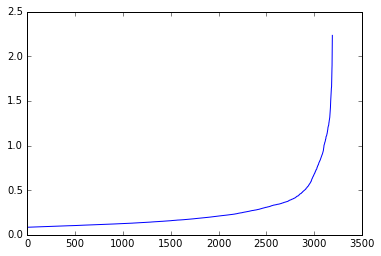

In [148]:
al_train_df, al_scores = active_learning(train_df, test_df, pool_df, 40000, 240)
# active_learning(train_df, test_df, pool_df, 40000, 240)

In [124]:
oracle_predict(temp.as_matrix()[:10])

array([[26.181371925673748, 10.948754419061121],
       [6.963157445563727, 1.3903902287806085],
       [13.543951869849625, 14.621560003434485],
       [0.6958972603987401, 64.01579330473115],
       [544.3824765653862, 2.3815617486125937], [], [], []], dtype=object)

In [129]:
np.concatenate([temp1])

array([[26.181371925673748, 10.948754419061121],
       [6.963157445563727, 1.3903902287806085],
       [13.543951869849625, 14.621560003434485],
       [0.6958972603987401, 64.01579330473115],
       [544.3824765653862, 2.3815617486125937], [], [], []], dtype=object)

In [111]:
70548921522.161743 > 122269859896.38976

False

In [44]:
def active_learning(train_df, test_df, pool_df, max_train, pack_size=80):
    global committee
    scores = []
    
#     while len(train_df) < max_train:
    for j in range(4):
        print j
        if len(scores) > 0:
            pool_sample_df = pool_df.sample(10000)
            print "   ", pool_sample_df.shape
            c_pred = np.array([c.predict(pool_sample_df.as_matrix()) for c in committee])
#             c_pred = P(n_jobs=8)(dl(pred_committee)(i, pool_sample_df.as_matrix()) for i in range(len(committee)))
            c_pred_std = np.std(c_pred, axis=0)
            interest_df = pool_sample_df.iloc[np.argsort(c_pred_std)[-pack_size-pack_size:-pack_size]]
            y_pred = oracle_predict(interest_df.as_matrix())

            oracle_df = pd.concat([interest_df, pd.Series(y_pred,
                                                          index=interest_df.index,
                                                          name="y")], axis=1)
            train_df = pd.concat([train_df, oracle_df])
            pool_df = pool_df.drop(oracle_df.index)

        print "  ", train_df.shape, test_df.shape, pool_df.shape

        committee = [c.fit(train_df.iloc[:,1:], train_df.iloc[:,0]) for c in committee]
        y_committee = np.array([c.predict(test_df.iloc[:,1:]) for c in committee])
        y_pred = np.mean(y_committee, axis=0)

        scores.append(rmse(test_df.iloc[:,0], y_pred))
        print scores
        plt.plot(range(len(scores)), scores)
        
    return train_df, scores

0
   (20000, 11) (7000, 11) (980000, 10)
[18454888487.776913]
1
    (10000, 10)


ValueError: zero-dimensional arrays cannot be concatenated

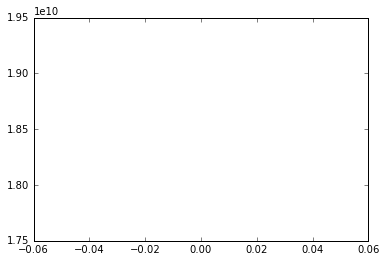

In [45]:
al_train_df, al_scores = active_learning(train_df, test_df, pool_df, 40000, 240)

In [30]:
np.arange(0.01, 1.0, 0.1)

array([ 0.01,  0.11,  0.21,  0.31,  0.41,  0.51,  0.61,  0.71,  0.81,  0.91])

In [31]:
from sklearn.grid_search import GridSearchCV

params = {'learning_rate': np.arange(0.01, 1.0, 0.2)}
gsc = GridSearchCV(GradientBoostingRegressor(n_estimators=2800, max_depth=5), params,
                       cv=5, scoring="mean_squared_error", n_jobs=8)
gsc.fit(train_df.iloc[:,1:], train_df.iloc[:,0])
print("Best parameters set found on development set:")
print()
print(gsc.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in gsc.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print()

Best parameters set found on development set:
()
{'learning_rate': 0.21000000000000002}
()
Grid scores on development set:
()
-1106216723421570924544.000 (+/-1630128657211112030208.000) for {'learning_rate': 0.01}
-1058063767085602832384.000 (+/-1500228326094929657856.000) for {'learning_rate': 0.21000000000000002}
-1278200119220578287616.000 (+/-1934491812402613977088.000) for {'learning_rate': 0.41000000000000003}
-1464297959947117002752.000 (+/-2132779931370038755328.000) for {'learning_rate': 0.6100000000000001}
-1696885822736067723264.000 (+/-2327461831870418518016.000) for {'learning_rate': 0.81000000000000005}
()


# Обучаемся на ошибке

In [178]:
br = BaggingRegressor(n_estimators=300, n_jobs=8, random_state=300+i, oob_score=True, )

In [180]:
br.fit(train_df.iloc[:,1:], train_df.iloc[:,0])

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=300, n_jobs=8, oob_score=True, random_state=302,
         verbose=0)

In [182]:
test_pred = br.predict(test_df.iloc[:,1:])
print rmse(test_df.iloc[:,0], test_pred)
print rmse(train_df.iloc[:,0], br.predict(train_df.iloc[:,1:]))

22407720907.7
11851407552.6


In [183]:
abs_error = np.abs(test_pred - test_df.iloc[:,0])
error = test_pred - test_df.iloc[:,0]

In [184]:
br_abs = br.fit(test_df.iloc[:,1:], abs_error)
br_def = br.fit(test_df.iloc[:,1:], error)

# br_abs

In [186]:
# br_abs
abs_sample = df_X.sample(6000)
abs_U_error = br_abs.predict(abs_sample) # предиктим ошибку

In [192]:
abs_inds = np.argsort(abs_U_error)[-50:]

In [213]:
abs_interest_x = abs_sample.iloc[abs_inds]
abs_interest_y = oracle_predict(abs_interest_x.as_matrix())

0 7
7 14
14 21
21 28
28 35
35 42
42 49
49 56


In [217]:
abs_interest_df = pd.concat([abs_interest_x, pd.Series(abs_interest_y,
                                                          index=abs_interest_x.index,
                                                          name="y")], axis=1)


In [220]:
abs_tmp_df = pd.concat([train_df, abs_interest_df])
br.fit(abs_tmp_df.iloc[:,1:], abs_tmp_df.iloc[:,0])

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=300, n_jobs=8, oob_score=True, random_state=302,
         verbose=0)

In [221]:
print rmse(test_df.iloc[:,0], br.predict(test_df.iloc[:,1:]))
print rmse(abs_tmp_df.iloc[:,0], br.predict(abs_tmp_df.iloc[:,1:]))

91516913732.4
0.142982455205


In [ ]:
22407720907.7 /

In [49]:
28552625858.331615, 28552625858.331615

True

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

In [60]:
x_train_df.shape

(46033, 10)

In [128]:
gbr = BaggingRegressor(n_estimators=300,n_jobs=8,random_state=300+i,oob_score=True)
gbr.fit(train_df.iloc[:,1:], train_df.iloc[:,0])

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=300, n_jobs=8, oob_score=True, random_state=302,
         verbose=0)

In [85]:
train_pred = gbr.predict(train_df.iloc[:,1:]) # , train_df.iloc[:,0]

In [141]:
train_diff = train_pred - train_df.iloc[:,0]

In [142]:
gbr.fit(train_df.iloc[:,1:], train_diff)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=300, n_jobs=8, oob_score=True, random_state=302,
         verbose=0)

Int64Index([736978, 178742, 183606, 442154, 542105,  41258, 348942, 932473,
            256895, 781563,
            ...
            889536, 624670, 249447, 705433, 827939, 473498, 668331, 970855,
            742342, 169294],
           dtype='int64', name=u'id', length=10000)


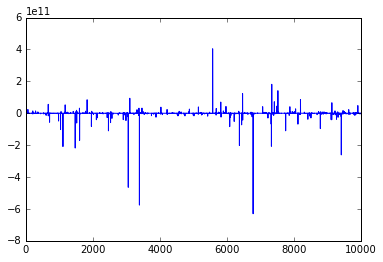

In [147]:
sample = train_df.iloc[:,1:].sample(10000)
print sample.index
error_pred = gbr.predict(sample)
plt.plot(error_pred)

In [125]:
error_pred

array([ -3.19208853e-02,   1.69065358e+04,   4.28523018e+01,
         6.79666473e+06,   1.08823268e+02,  -2.29566705e+01,
        -1.42559157e+01,  -2.48976837e+05,   5.16621877e+03,
         4.02904740e+05])

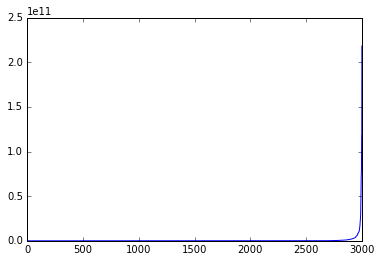

In [116]:
plt.plot(np.sort(np.abs(error_pred)))

# BRUTEFORCE

In [164]:
gbr = GradientBoostingRegressor(n_estimators=3000, max_depth=5, learning_rate=0.02, random_state=300)
gbr.fit(train_df.iloc[:,1:], train_df.iloc[:,0])

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.02, loss='ls',
             max_depth=5, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             random_state=300, subsample=1.0, verbose=0, warm_start=False)

In [165]:
Y = gbr.predict(df_X.as_matrix())

In [166]:
Y_df = pd.Series(Y, index=df_X.index, name="y")

In [167]:
Y_df.to_csv("submission4.csv", header=True)

In [ ]:
len(y_train_df), len(x_train_df)

In [ ]:
len(df_y)

In [ ]:
x_train_df = df_X.loc[df_y.index]
y_train_df = df_y

In [ ]:
x_data = x_train_df.as_matrix()
y_data = y_train_df.as_matrix().ravel()

In [ ]:
y_train_df.as_matrix().ravel()

In [ ]:
x_pool_df = df_X.drop(df_y.index)
x_pool = x_pool_df.as_matrix()

In [ ]:
x_data = x_data[:10000]
y_data = y_data[:10000]

In [ ]:
from sklearn import cross_validation as cv
from sklearn.metrics import mean_squared_error

In [ ]:
x_train, x_test, y_train, y_test = cv.train_test_split(x_data, y_data,
                                                           test_size=0.33, random_state=288)

In [ ]:
def oracle(x):
    query = "java -cp ./OracleRegression.jar Oracle"
    for xi in x:
        query += " " + str(xi)
    return float(commands.getoutput(query))

# Pool-based sampling
## Query by Committee
### Max Variance

In [ ]:
from joblib import Parallel as P
from joblib import delayed as dl

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

![](http://take.ms/VoqnT)

In [ ]:
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
regressors_dict = {
    0: {
        'r': GradientBoostingRegressor,
        'p': {"n_estimators":250}
    },
    1: {
        'r': RandomForestRegressor,
        'p': {"n_estimators":250}
    },
    2: {
        'r': AdaBoostRegressor,
        'p': {"n_estimators":250}
    },
    3: {
        'r': ElasticNet,
        'p': {}
    },
    4: {
        'r': LinearRegression,
        'p': {"n_jobs":8}
    },
    5: {
        'r': SVR,
        'p': {"n_estimators":250}
    },
}


regressor1 = GradientBoostingRegressor(n_estimators=250, max_depth=10, random_state=270)
regressor2 = RandomForestRegressor(n_estimators=250, max_depth=10, n_jobs=8, random_state=281)
regressor3 = RandomForestRegressor(n_estimators=250, max_depth=10, n_jobs=8, random_state=280)
regressor4 = BaggingRegressor(n_estimators=250, n_jobs=8, random_state=300, oob_score=True)
regressor5 = BaggingRegressor(n_estimators=250, n_jobs=8, random_state=140, oob_score=True)
regressor6 = BaggingRegressor(n_estimators=250, n_jobs=8, random_state=140, oob_score=True)
regressor7 = BaggingRegressor(n_estimators=250, n_jobs=8, random_state=140, oob_score=True)
# regressor3 = AdaBoostRegressor(n_estimators=250, )
# regressor4 = ElasticNet()
# regressor5 = LinearRegression(n_jobs=8)
# regressor6 = SVR()
regressors = [
    regressor4,
    regressor5,
    regressor6,
    regressor7,
]

In [ ]:
from sklearn.grid_search import GridSearchCV

In [ ]:
import time
s = time.time()
[regressor.fit(x_train, y_train) for regressor in regressors]
print time.time() - s

In [ ]:
scores = [rmse(y_test, regressor.predict(x_test)) for regressor in regressors]

In [ ]:
pool_pred = np.array([regressor.predict(x_pool) for regressor in regressors])

In [ ]:
pool_std = np.std(pool_pred, axis=0)

In [ ]:
worse80 = np.argsort(pool_std)[-80:]

In [ ]:
worse80_from_pool = x_pool_df.iloc[worse80].index

In [ ]:
def call_papa(i, indices):
#     return P(n_jobs=8)(dl(oracle)(x_pool_df.loc[ind]) for ind in indices[i*10:i*10 + 10])
    return [oracle(x_pool_df.loc[ind]) for ind in indices[i*10:i*10 + 10]]

In [ ]:
s = time.time()
from_papa = np.array(P(n_jobs=8)(dl(call_papa)(i, worse80_from_pool) for i in range(8))).ravel()
print time.time() - s

In [ ]:
x_pool_df.loc[worse80_from_pool]
from_papa

In [ ]:
np.argmin(scores)

In [ ]:
scores

In [ ]:
def active_learning(train_df, test_df, pool_df, committee, max_train, pack_size=80):
    scores = []
    
    for len(train_df) < max_train:
        if len(scores) > 0:
            c_pred = np.array([c.predict(pool_df.as_matrix()) for c in committeem])
            c_pred_std = np.std(c_pred, axis=0)
            interest_df = pool_df.iloc[np.argsort(c_pred_std)[-pack_size:]]
            y_pred = oralce(interest_df.as_matrix())
            
            oracle_df = pd.concat([interest_df, pd.Series(y_pred,
                                                          index=interest_df.index,
                                                          name="y")], axis=1)
            train_df = pd.concat([train_df, oracle_df])
            
        pass

In [ ]:
x_train_df.index

In [ ]:
y_train_df.index

In [ ]:
oracle(x_train_df.iloc[0])

In [ ]:
df = pd.concat([y_train_df, x_train_df], axis=1)

In [ ]:
df.iloc[:, 1:]

In [ ]:
pd.concat([pd.DataFrame([1,2,3,4]), pd.Series([1,2,3,4], name="label")], axis=1)

In [69]:
df_X[100:].index[10]

110

In [74]:
df_X[100:].ix[110]

x_0    3.378987
x_1    0.779177
x_2    3.706624
x_3    1.115239
x_4    3.489957
x_5    2.406349
x_6    3.674683
x_7    3.918399
x_8    0.922906
x_9    2.812284
Name: 110, dtype: float64

In [ ]:
874837,1408.5484951805192
826466,6.297917259062075
859199,4.516114511788225
851128,1.1994851608453336E9
818098,1.074580581110529E7
853653,770550.38805992

In [95]:
oracle(df_X.ix[770006])

2.283685144992138